In [1]:
import numpy as np
import pandas as pd
from math import isnan, sqrt
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
hiae = pd.read_csv("data/hiae.csv")
hmvsc = pd.read_csv("data/hmvsc.csv")

## Data prep

In [3]:
# Valid variable thresholds
thresholds = {
    'highest_respiratory_rate1h': [10, 40],
    'highest_temperature1h': [30, 42],
    'highest_heart_rate1h': [20, 220],
    'lowest_mean_arterial_pressure1h': [20, 150],
    'lowest_diastolic_blood_pressure1h': [20, 200],
    'lowest_systolic_blood_pressure1h': [30, 250],
    'bmi': [10, 70]
}

In [4]:
normal = {
    'highest_respiratory_rate1h': 16,
    'highest_temperature1h': 37,
    'highest_heart_rate1h': 80,
    'lowest_mean_arterial_pressure1h': 90,
    'lowest_diastolic_blood_pressure1h': 80,
    'lowest_systolic_blood_pressure1h': 120,
    'lengthhospitalstaypriorunitadmission': 0
}

In [5]:
# Function to remove invalid thresholds
def remove_invalid(df, thresholds):
    for c in thresholds:
        df.loc[(df[c] < thresholds[c][0]) | (df[c] > thresholds[c][1]), c] = np.nan

In [6]:
# Remove invalid thresholds
remove_invalid(hiae, thresholds)
remove_invalid(hmvsc, thresholds)

In [7]:
# Group glasgow
def group_gcs(gcs):
    if isnan(gcs):
        return np.nan
    
    gcs = int(gcs)
    if gcs < 15:
        return 1
    elif gcs == 15:
        return 2

In [8]:
def group_adm_src(df):
     df['admissionsourcename'].replace({
         'Enfermaria / quarto': 'floor',
         'Centro Cirúrgico': 'operating room',
         'Sala de hemodinâmica': 'operating room',
         'Emergência': 'emergency room',
         'Home-care': 'emergency room', 
         'Transferência de outro hospital/instituição': 'other sources',
         'Outra UTI/UCI do seu hospital': 'other icu',
         'Unidade Semi-intensiva': 'other sources',
         'Outra - Não especificada': 'other sources'
     }, inplace=True)

In [9]:
# Group gcs
hiae['glasgow'] = hiae['lowest_glasgow_coma_scale1h'].apply(group_gcs)
hmvsc['glasgow'] = hmvsc['lowest_glasgow_coma_scale1h'].apply(group_gcs)

# Group admission source
group_adm_src(hiae)
group_adm_src(hmvsc)

In [10]:
class CustomImputer:
    """
    Impute mode for each categorical column and pre-defined normal values otherwise.
    """
    def __init__(self, normal, c_cols):
        self.normal = normal
        self.c_cols = c_cols

    def fit(self, X, y=None):
        self.modes = [(c, X[c].dropna().mode()[0]) for c in self.c_cols]
        return self

    def transform(self, X):
        output = X.copy()
        for c, v in self.normal.items():
            output[c].fillna(v, inplace=True)
        for c, v in self.modes:
            output[c].fillna(v, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [11]:
class CustomLabelEncoder:
    def __init__(self, values):
        self.values = values

    def fit(self, X, y=None):
        self.encoders = [(c, LabelEncoder().fit(v)) for c, v in self.values]
        return self

    def transform(self, X):
        output = X.copy()
        for c, e in self.encoders:
            output.loc[output[c].notna(), c] = e.transform(output.loc[output[c].notna(), c])
            output[c].fillna(-1, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [12]:
class OneHotEncoder:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()
        output = pd.get_dummies(output, columns=self.columns, drop_first=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [13]:
class CustomScaler:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.scalers = [(c, StandardScaler().fit(X[c].astype(float).values.reshape(-1,1))) for c in self.columns]
        return self

    def transform(self, X):
        output = X.copy()
        for c, s in self.scalers:
            output[c] = s.transform(output[c].astype(float).values.reshape(-1,1))
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [14]:
def smr_score(y_true, y_pred):
    return sum(y_true)/sum(y_pred)

In [15]:
# Lists of variable types
target = "hospitalexpireflag"

#pre icu
demographic = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name",
               "age", "lengthhospitalstaypriorunitadmission", "bmi_group"]

#lab results
physiological = ["lowest_systolic_blood_pressure1h", "lowest_diastolic_blood_pressure1h",
                 "lowest_mean_arterial_pressure1h", "highest_heart_rate1h", "highest_respiratory_rate1h",
                 "highest_temperature1h"]

glasgow = ["glasgow"]
                 
c_cols_og = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name", 
          "glasgow", "bmi_group"]

n_cols_og = ["age", "lowest_systolic_blood_pressure1h", 
          "lowest_diastolic_blood_pressure1h","lowest_mean_arterial_pressure1h", "highest_heart_rate1h", 
          "highest_respiratory_rate1h", "highest_temperature1h", "lengthhospitalstaypriorunitadmission"]

### Helper Functions To Run The Models

In [16]:
def plot_calib_curve(y_true, y_pred, ax = None, n_bins = 10, with_histogram=False, width=0.1, **kwargs):
    if type(y_true) is list:
        y_true = np.asarray(y_true)
    if type(y_pred) is list:
        y_pred = np.asarray(y_pred)
        
    # Metrics Logit
    if ax is None:
        ax=plt.gca()
        
    # calculate SMR
    smr = smr_score(y_true, y_pred)
    smr_ci = ci(smr_score, y_true, y_pred)
    
    # calculate AUROC
    auc = roc_auc_score(y_true, y_pred)
    auc_ci = ci(roc_auc_score, y_true, y_pred)
    
    # add AUROC to legend
    if 'label' not in kwargs:
        kwargs['label'] = ''
    
    xi = np.linspace(0, 1, n_bins+1)
    
    expected  = np.ones(n_bins)*np.nan
    observed = np.ones(n_bins)*np.nan
    N = np.zeros(n_bins)
    for i in range(len(xi)-1):
        idx = (y_pred > xi[i]) & (y_pred <= xi[i+1])
        if np.any(idx):
            expected[i] = np.sum(y_pred[idx])
            observed[i] = np.sum(y_true[idx])
            N[i] = np.sum(idx)
        
    
    # calibration curve
    p = ax.plot(expected/N, observed/N, **kwargs)
    
    if with_histogram:
        # add transparent histogram
        c = p[0].get_color()
        ax.bar(expected/N, N/np.sum(N), width=width, alpha=0.5, facecolor=c)
        
    print(kwargs['label'] + "\tAUC - {:0.2f} ({:0.2f} - {:0.2f} 95% CI)".format(auc, auc_ci[0], auc_ci[1]))
    print(kwargs['label'] + "\tSMR - {:0.2f} ({:0.2f} - {:0.2f} 95% CI)".format(smr, smr_ci[0], smr_ci[1]))

In [17]:
def columns2block(block):
    if block == 1:
        columns = physiological
    elif block == 2:
        columns = demographic
    elif block == 3:
        columns = physiological + demographic
    elif block == 4:
        columns = physiological + demographic + glasgow
    return columns

In [18]:
def ci(metric, y_true, y_pred, confidence=0.95, samples=2000):
    '''Confidence Interval calculator'''
    
    scores = []
    np.random.RandomState(42)
    for i in range(samples):
        indices = np.random.randint(0, len(y_pred) - 1, len(y_pred))
        scores.append(metric(y_true[indices], y_pred[indices]))
    scores = np.sort(scores)
    
    n = len(scores)
    lower = int( (1 - confidence) / 2 * n )
    upper = int( (1 + confidence) / 2 * n )
    
    return (scores[lower], scores[upper])

In [26]:
def prep_data_and_pipeline(hiae, hmvsc, columns, target, model='lr'):
    # Seperate x and y values
    X_hiae = hiae[columns].copy()
    X_hmvsc = hmvsc[columns].copy()
    
    y_hiae = hiae[target].copy()
    y_hmvsc = hmvsc[target].copy()    
    
    # Create null flag column
    if model != 'xgb':
        for c in X_hiae.columns:
            X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
            X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

    # Get unique values for categorical features, after filtering the columns according to each block
    c_cols = [c for c in c_cols_og if c in X_hiae.columns]
    n_cols = [n for n in n_cols_og if n in X_hiae.columns]

    values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

    # Normal values filtered for each block
    filtered_normal = {}
    for key in normal.keys():
        if key in n_cols: filtered_normal[key] = normal[key]
    
    if model  == 'lr':
        # Model
        logr = LogisticRegression(solver='liblinear', penalty='l1')
        # Create pipeline
        pipe = Pipeline([
            ("imputer", CustomImputer(filtered_normal, c_cols)),
            ("lenc", CustomLabelEncoder(values)),
            ("ohe", OneHotEncoder(c_cols)),
            ("scaler", CustomScaler(n_cols)),
            ("model", logr)
        ])
    elif model == 'xgb':
        # Model
        xbst = XGBClassifier(n_estimators=100, max_depth=2)
        # Create pipeline
        pipe = Pipeline([
            ("lenc", CustomLabelEncoder(values)),
            ("model", xbst)
        ])
    elif model == 'xgbi':
        # Model
        xgbi = XGBClassifier(n_estimators=100, max_depth=2)
        # Create pipeline
        pipe = Pipeline([
            ("imputer", CustomImputer(filtered_normal, c_cols)),
            ("lenc", CustomLabelEncoder(values)),
            ("model", xgbi)
        ])
    else:
        raise ValueError('Unrecognized model.')
        
    return X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe

## Logit trained in HIAE data

HIAE	AUC - 0.66 (0.63 - 0.68 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.65 (0.62 - 0.68 95% CI)
HMVSC	SMR - 2.15 (1.94 - 2.36 95% CI)


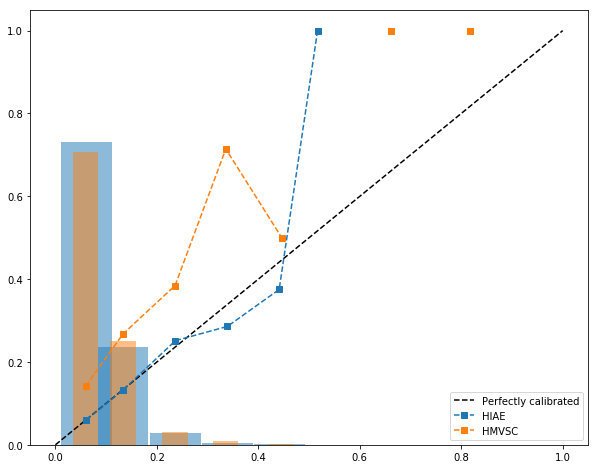

HIAE	AUC - 0.77 (0.75 - 0.79 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.76 (0.73 - 0.79 95% CI)
HMVSC	SMR - 2.32 (2.11 - 2.54 95% CI)


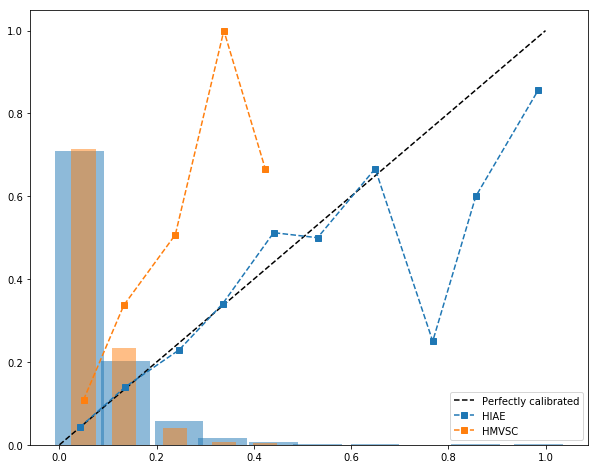

HIAE	AUC - 0.80 (0.78 - 0.82 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.07 95% CI)
HMVSC	AUC - 0.79 (0.76 - 0.81 95% CI)
HMVSC	SMR - 2.17 (1.97 - 2.37 95% CI)


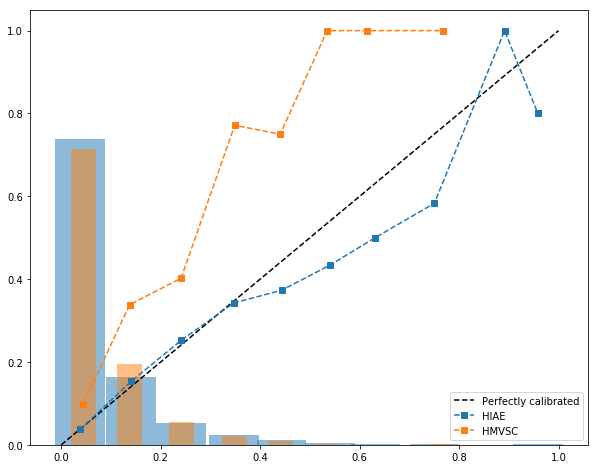

HIAE	AUC - 0.83 (0.81 - 0.85 95% CI)
HIAE	SMR - 1.00 (0.93 - 1.07 95% CI)
HMVSC	AUC - 0.84 (0.81 - 0.86 95% CI)
HMVSC	SMR - 1.94 (1.77 - 2.10 95% CI)


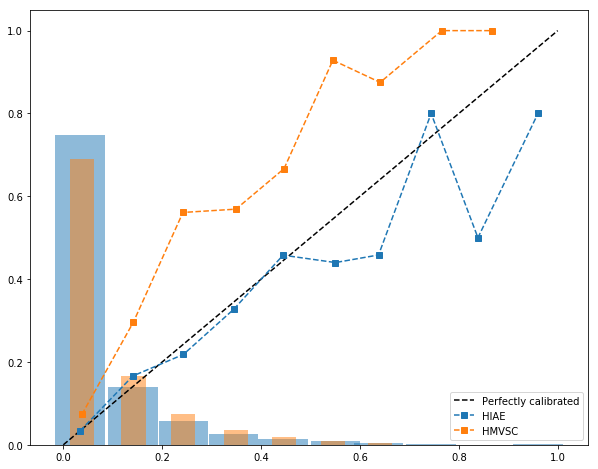

In [27]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='lr')
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    # Save probs
    np.savetxt("observed_block"+str(block)+".txt", y_true_hmvsc)
    np.savetxt("probabilities_block"+str(block)+".txt", y_pred_hmvsc)
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()

## XGBoost trained in HIAE data

HIAE	AUC - 0.66 (0.63 - 0.69 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.65 (0.62 - 0.69 95% CI)
HMVSC	SMR - 2.03 (1.83 - 2.23 95% CI)


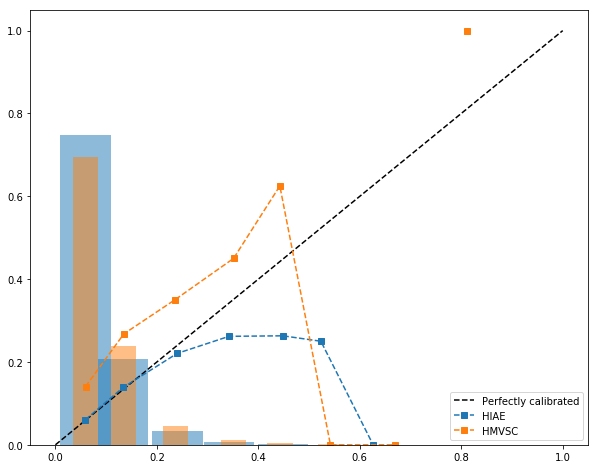

HIAE	AUC - 0.78 (0.76 - 0.80 95% CI)
HIAE	SMR - 1.00 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.74 (0.71 - 0.77 95% CI)
HMVSC	SMR - 2.57 (2.31 - 2.81 95% CI)


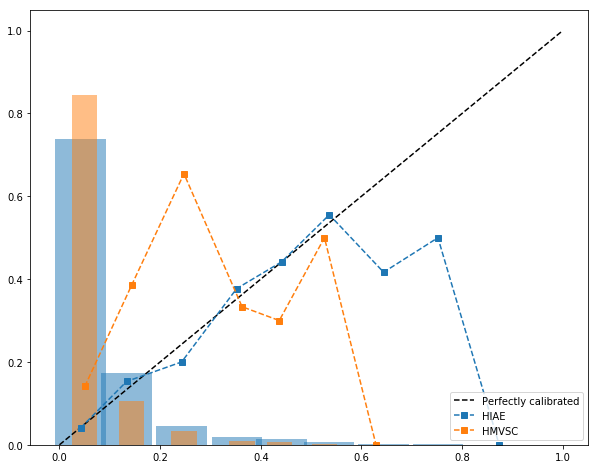

HIAE	AUC - 0.81 (0.79 - 0.83 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.77 (0.74 - 0.80 95% CI)
HMVSC	SMR - 2.45 (2.23 - 2.68 95% CI)


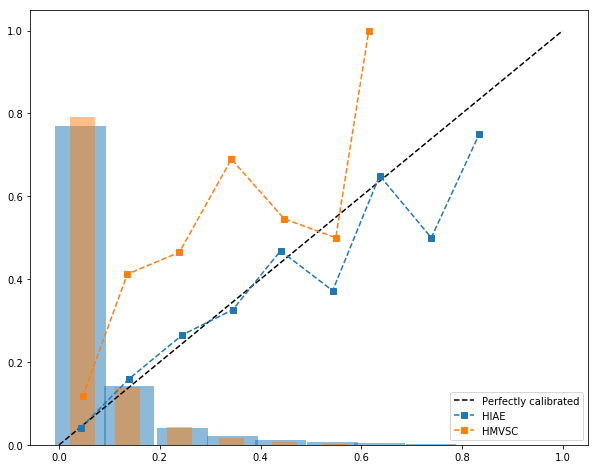

HIAE	AUC - 0.83 (0.82 - 0.85 95% CI)
HIAE	SMR - 1.01 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.83 (0.80 - 0.86 95% CI)
HMVSC	SMR - 2.18 (1.98 - 2.37 95% CI)


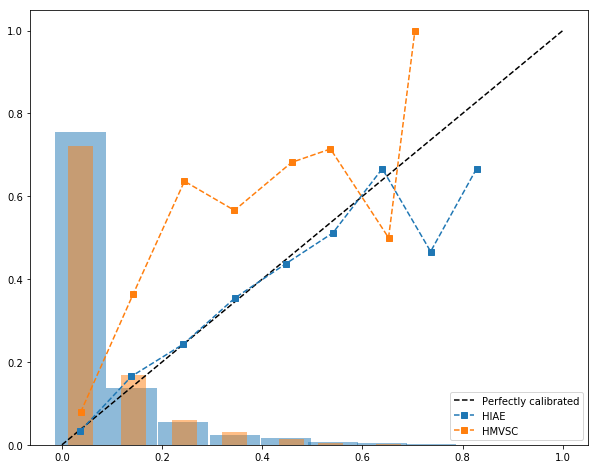

In [28]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='xgb')
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()

## XGBoost trained in HIAE imputed data

HIAE	AUC - 0.67 (0.64 - 0.69 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.09 95% CI)
HMVSC	AUC - 0.65 (0.61 - 0.68 95% CI)
HMVSC	SMR - 2.07 (1.88 - 2.29 95% CI)


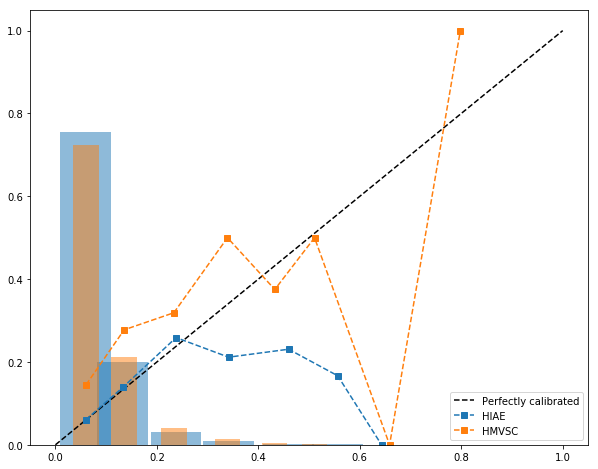

HIAE	AUC - 0.78 (0.76 - 0.80 95% CI)
HIAE	SMR - 1.00 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.75 (0.71 - 0.78 95% CI)
HMVSC	SMR - 2.54 (2.29 - 2.81 95% CI)


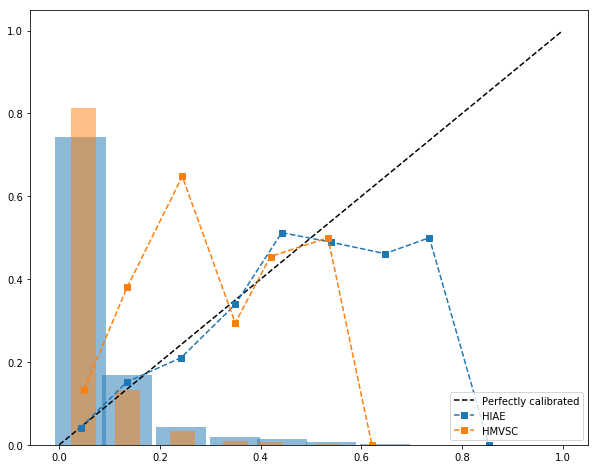

HIAE	AUC - 0.81 (0.79 - 0.83 95% CI)
HIAE	SMR - 1.00 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.76 (0.73 - 0.79 95% CI)
HMVSC	SMR - 2.50 (2.27 - 2.73 95% CI)


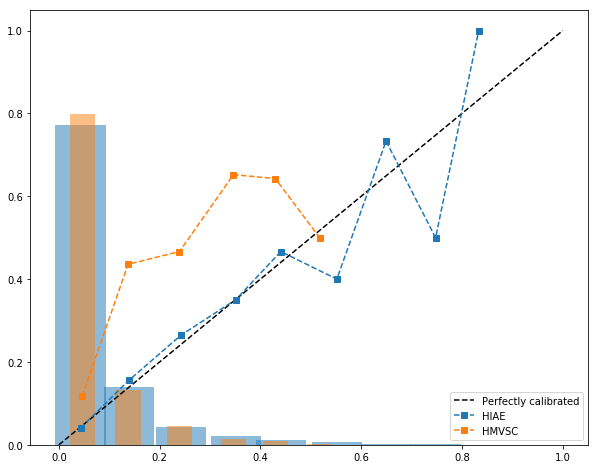

HIAE	AUC - 0.83 (0.82 - 0.85 95% CI)
HIAE	SMR - 1.01 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.83 (0.80 - 0.86 95% CI)
HMVSC	SMR - 2.28 (2.08 - 2.48 95% CI)


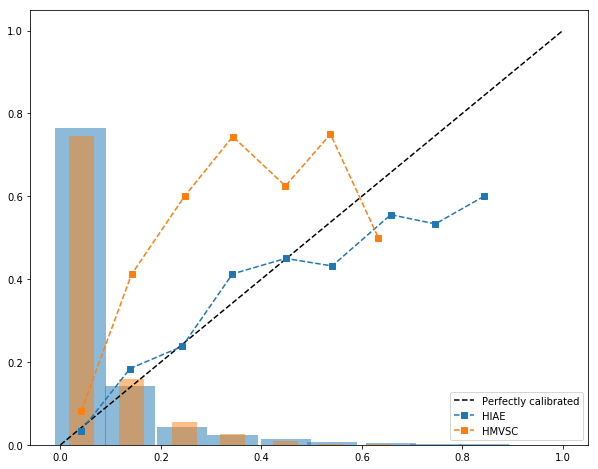

In [29]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='xgbi')
    
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()

## Calibrated Logit Block 4

In [30]:
''' Feature Selection '''

# Get columns for current block
columns = columns2block(4)

# Seperate x and y values
X_hiae = hiae[columns].copy()
X_hmvsc = hmvsc[columns].copy()

y_hiae = hiae[target].copy()
y_hmvsc = hmvsc[target].copy()    

# Create null flag column
for c in X_hiae.columns:
    X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
    X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

# Get unique values for categorical features, after filtering the columns according to each block
c_cols = [c for c in c_cols_og if c in X_hiae.columns]
n_cols = [n for n in n_cols_og if n in X_hiae.columns]

values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

# Normal values filtered for each block
filtered_normal = {}
for key in normal.keys():
    if key in n_cols: filtered_normal[key] = normal[key]

auc = np.array([])
c_val = np.linspace(0.01,1,100)
for C in c_val:
    # Model
    logr = LogisticRegression(solver='liblinear', penalty='l1', C=C)

    # Create pipeline
    pipe = Pipeline([
        ("imputer", CustomImputer(filtered_normal, c_cols)),
        ("lenc", CustomLabelEncoder(values)),
        ("ohe", OneHotEncoder(c_cols)),
        ("scaler", CustomScaler(n_cols)),
        ("model", logr)
    ])

    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(pipe, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]

    auc = np.append(auc, roc_auc_score(y_true_hiae, y_pred_hiae))

# Find C-value one stardard deviation away from best performing auc
std = np.std(auc)
mmo = np.max(auc) - std
print("Best C-value:")
print(c_val[np.argmax(auc)])

for i, a in enumerate(auc):
    if a >= mmo: 
        C = c_val[i]
        break

# Create pipeline
pipe = Pipeline([
    ("imputer", CustomImputer(filtered_normal, c_cols)),
    ("lenc", CustomLabelEncoder(values)),
    ("ohe", OneHotEncoder(c_cols)),
    ("scaler", CustomScaler(n_cols)),
])

# Transform data
X_hiae = pipe.fit_transform(X_hiae, y_hiae)

# Model
logr = LogisticRegression(solver='liblinear', penalty='l1', C=C)
logr.fit(X_hiae, y_hiae)

# Get coefficients
print("-----COEFFICIENTS-----")
lenc = pipe.named_steps["lenc"].encoders
coef = logr.coef_[0]
for i, c in enumerate(X_hiae.columns):
    for ec, le in lenc:
        if ec not in c or "null" in c: continue
        v = int(c[-1])
        c = c[:-2] + " - " + str(le.inverse_transform(v))
    print(c+ ": " + str
          (round(coef[i],2)))
print("-----------------------\n")

Best C-value:
0.31
-----COEFFICIENTS-----
lowest_systolic_blood_pressure1h: -0.25
lowest_diastolic_blood_pressure1h: 0.0
lowest_mean_arterial_pressure1h: 0.0
highest_heart_rate1h: 0.3
highest_respiratory_rate1h: 0.12
highest_temperature1h: -0.19
age: 0.52
lengthhospitalstaypriorunitadmission: 0.56
lowest_systolic_blood_pressure1h_null: 0.0
lowest_diastolic_blood_pressure1h_null: 0.0
lowest_mean_arterial_pressure1h_null: 0.0
highest_heart_rate1h_null: 0.0
highest_respiratory_rate1h_null: 0.0
highest_temperature1h_null: 0.0
genders_null: 0.0
admissionsourcename_null: 0.0
admissiontypename_null: 0.0
chronic_health_status_name_null: 0.0
age_null: 0.0
lengthhospitalstaypriorunitadmission_null: 0.0
bmi_group_null: 0.0
glasgow_null: 1.01
genders - 1.0: -0.05
admissionsourcename - floor: 0.1
admissionsourcename - operating room: -0.5
admissionsourcename - other icu: 0.0
admissionsourcename - other sources: 0.32
admissiontypename - Cirurgia eletiva: -0.52
admissiontypename - Clínica: 0.0
chroni

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

-----COEFFICIENTS-----
lowest_systolic_blood_pressure1h: -0.3
highest_heart_rate1h: 0.33
highest_respiratory_rate1h: 0.17
highest_temperature1h: -0.26
age: 0.57
lengthhospitalstaypriorunitadmission: 0.58
lowest_systolic_blood_pressure1h_null: 0.0
highest_heart_rate1h_null: 0.0
highest_respiratory_rate1h_null: 0.0
highest_temperature1h_null: 0.64
genders_null: 0.0
admissionsourcename_null: 0.0
admissiontypename_null: 0.0
age_null: 0.0
lengthhospitalstaypriorunitadmission_null: 0.0
glasgow_null: 1.37
genders - 1.0: -0.11
admissionsourcename - floor: 0.56
admissionsourcename - operating room: -0.42
admissionsourcename - other icu: 0.76
admissionsourcename - other sources: 0.66
admissiontypename - Cirurgia eletiva: -0.74
admissiontypename - Clínica: 0.0
glasgow - 2.0: -1.08
-----------------------



/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

HIAE	AUC - 0.83 (0.81 - 0.84 95% CI)
HIAE	SMR - 0.99 (0.92 - 1.07 95% CI)
HMVSC	AUC - 0.84 (0.81 - 0.86 95% CI)
HMVSC	SMR - 1.00 (0.91 - 1.08 95% CI)


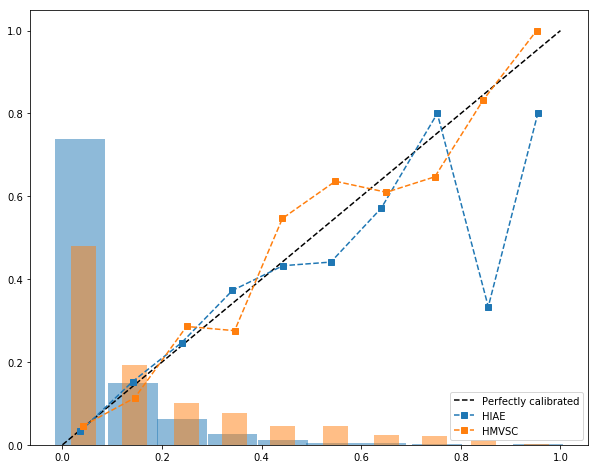

In [31]:
''' Remove features and recalibrate '''

block = 4

# Get columns for current block
columns = columns2block(4)

# Seperate x and y values
X_hiae = hiae[columns].copy()
X_hmvsc = hmvsc[columns].copy()

y_hiae = hiae[target].copy()
y_hmvsc = hmvsc[target].copy()  

# Remove columns excluded from feature selection
X_hmvsc.drop("lowest_diastolic_blood_pressure1h", axis=1, inplace=True)
X_hiae.drop("lowest_diastolic_blood_pressure1h", axis=1, inplace=True)
X_hmvsc.drop("lowest_mean_arterial_pressure1h", axis=1, inplace=True)
X_hiae.drop("lowest_mean_arterial_pressure1h", axis=1, inplace=True)
X_hmvsc.drop("chronic_health_status_name", axis=1, inplace=True)
X_hiae.drop("chronic_health_status_name", axis=1, inplace=True)
X_hmvsc.drop("bmi_group", axis=1, inplace=True)
X_hiae.drop("bmi_group", axis=1, inplace=True)

# Create null flag column
for c in X_hiae.columns:
    X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
    X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

# Get unique values for categorical features, after filtering the columns according to each block
c_cols = [c for c in c_cols_og if c in X_hiae.columns]
n_cols = [n for n in n_cols_og if n in X_hiae.columns]

values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

# Normal values filtered for each block
filtered_normal = {}
for key in normal.keys():
    if key in n_cols: filtered_normal[key] = normal[key]

# Model
logr = LogisticRegression(solver='liblinear', penalty='l1', C=c_val[np.argmax(auc)])

# Create pipeline
pipe = Pipeline([
    ("imputer", CustomImputer(filtered_normal, c_cols)),
    ("lenc", CustomLabelEncoder(values)),
    ("ohe", OneHotEncoder(c_cols)),
    ("scaler", CustomScaler(n_cols))
])

#== train model on hiae
X_hiae = pipe.fit_transform(X_hiae)
model = logr.fit(X_hiae, y_hiae)

# also get cross-validation performance on hiae
y_true_hiae = np.array(y_hiae)
y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]

# transform hmvsc data
X_hmvsc = pipe.transform(X_hmvsc)

# recalibrate model
model = CalibratedClassifierCV(model, cv='prefit')
model.fit(X_hmvsc, y_hmvsc)

# Get coefficients
print("-----COEFFICIENTS-----")
lenc = pipe.named_steps["lenc"].encoders
coef = model.base_estimator.coef_[0]
for i, c in enumerate(X_hmvsc.columns):
    for ec, le in lenc:
        if ec not in c or "null" in c: continue
        v = int(c[-1])
        c = c[:-2] + " - " + str(le.inverse_transform(v))
    print(c+ ": " + str(round(coef[i],2)))
print("-----------------------\n")
    
#== make predictions
y_true_hmvsc = np.array(y_hmvsc)
y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]

# plot performance
plt.figure(figsize=[10,8])
ax = plt.gca()
ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                 with_histogram=True, width=0.1,
                 marker="s", linestyle='--', label="HIAE")
plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                 with_histogram=True, width=0.05,
                 marker="s", linestyle='--', label="HMVSC")

plt.legend(loc='lower right')
plt.show()